In [130]:
import pyemma
import glob
import numpy as np
import pyemma.plots as mplt
%pylab inline
import mdtraj as md
 
import pyemma.coordinates as coor
 
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res
 
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg



Populating the interactive namespace from numpy and matplotlib


In [131]:
traj=md.load("/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_stride10.xtc", top= "protein.h5")


In [132]:
traj=traj.superpose(traj,0)

trajfile="/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_stride10.xtc"

print(traj)

<mdtraj.Trajectory with 35000 frames, 3324 atoms, 220 residues, and unitcells>


In [133]:
print(traj.topology.residue(187))

TRP187


In [134]:
feat = coor.featurizer(traj.topology)
feat.add_residue_mindist([[146,187],[116,136],[142,143],[71,212],[27,29],[117,187],[64,160],[119,20],[216,191],[24,146],[114,119]], scheme="closest-heavy")
print(feat.describe()[:13])

['RES_DIST (closest-heavy) PHE146 - TRP187', 'RES_DIST (closest-heavy) GLU116 - SER136', 'RES_DIST (closest-heavy) ARG142 - HIS143', 'RES_DIST (closest-heavy) PHE71 - PHE212', 'RES_DIST (closest-heavy) TRP27 - PHE29', 'RES_DIST (closest-heavy) LEU117 - TRP187', 'RES_DIST (closest-heavy) ASN64 - THR160', 'RES_DIST (closest-heavy) TYR119 - GLN20', 'RES_DIST (closest-heavy) PRO216 - PHE191', 'RES_DIST (closest-heavy) GLY24 - PHE146', 'RES_DIST (closest-heavy) TYR114 - TYR119']


In [112]:
##
count=0
for i in range(0,219):
    
    print(traj.topology.residue(i))
    res=traj.topology.residue(i)
    Res=str(res)[3:]
    #print(Res)
    #print(count)
    if Res!=str(count):
        print(Res)
    count=count+1
#print(count)

IndentationError: expected an indented block (<ipython-input-112-7060bf45d366>, line 11)

In [135]:
feat.add_minrmsd_to_ref(traj[0])
inp = coor.source(trajfile, feat)
print(inp)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

trajectory length =  35000
number of dimension =  12


Projected data shape =  (35000, 3)
Mean values:  [-0.01352142  0.00720704 -0.00932027]
Variances:    [1.0253463 1.0047953 1.0034226]
[911.59508712 509.77675497 410.42796897 303.57031241          nan]


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


04-11-18 06:22:05 pyemma.coordinates.clustering.kmeans.KmeansClustering[36] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
[array([ 5,  5,  5, ...,  6, 17, 17], dtype=int32)]
35000


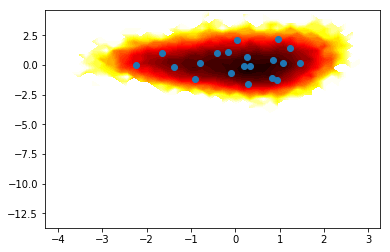

In [137]:
lag=1000
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.95, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
print('Projected data shape = ', Y.shape)

print('Mean values: ', np.mean(Y, axis=0))
print('Variances:   ', np.var(Y, axis=0))
print(-lag/np.log(tica_obj.eigenvalues[:5]))
 
# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)

cl = coor.cluster_kmeans(data=Y,k=20)

#cl=coor.cluster_uniform_time(data=Y, )
# for later use we save the discretetrajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
 
 
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')
 
print(dtrajs)
print(np.size(dtrajs))


[-0.9070979  -0.10382464  0.27213818  1.462312   -0.4218093   0.9341136
 -0.7985725   0.32853818  0.28413087  0.20357832 -0.15489595  0.83207524
  1.0823798   0.04216963  1.2269428   0.9689692  -2.2461834  -1.6548023
  0.85639024 -1.3858418 ]
[-1.1392723  -0.6406893   0.670212    0.17385975  0.9832789  -1.2434176
  0.14043956 -0.07873771 -1.6307967  -0.11754949  1.0719994  -1.0669212
  0.15786389  2.069457    1.4257292   2.1719785   0.01276813  1.0233815
  0.42640015 -0.1907177 ]


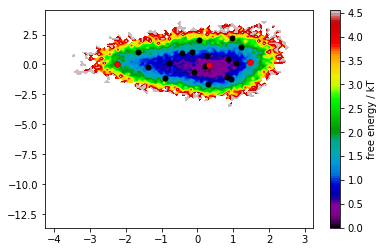

In [165]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

plot(cc_x[16], cc_y[16],linewidth=0, marker='o', markersize=5, color="red")
plot(cc_x[7], cc_y[7],linewidth=0, marker='o', markersize=5, color="red")
plot(cc_x[3], cc_y[3],linewidth=0, marker='o', markersize=5, color="red")

print(cc_x)
print(cc_y)

In [139]:
tica_obj.feature_TIC_correlation

array([[ 0.05119673, -0.00439196,  0.06938441],
       [ 0.0487583 ,  0.07684492,  0.00427713],
       [ 0.00329557,  0.04059269, -0.0098932 ],
       [ 0.50279382,  0.37225297, -0.70168208],
       [-0.10644385,  0.03938872,  0.01749548],
       [ 0.05567819,  0.01053296, -0.26695242],
       [-0.84530593,  0.2336927 , -0.25529595],
       [-0.01074839, -0.21788376,  0.14396821],
       [ 0.20051536,  0.10106722, -0.13856134],
       [ 0.24785353, -0.16574521,  0.22401976],
       [-0.07395636,  0.04837702,  0.0818202 ],
       [-0.20650364,  0.67356478,  0.62774396]])

In [140]:
tica_obj.cumvar

array([0.7822967 , 0.92107874, 0.97476882, 0.98442822, 0.98984175,
       0.99450461, 0.99785248, 0.99968597, 0.99985107, 0.99998884,
       0.99999943, 1.        ])

In [147]:
print(dtrajs)
dtraj=max(dtrajs)
print(dtraj)


[array([ 5,  5,  5, ...,  6, 17, 17], dtype=int32)]
[ 5  5  5 ...  6 17 17]


In [151]:
Clusters={}

for count in range(0,20):
    frames=[]
    indices = [d for d, x in enumerate(dtraj) if x == count]
    frames.append(indices)
    Clusters[count]=frames
#print(Clusters)


In [150]:
for key in Clusters:
    print(key)
    a=traj[Clusters[key]]
    print(a)
    a.save_xtc('TICA_res_dis_Traj/Trajcluster_all'+str(key)+".xtc")

0
<mdtraj.Trajectory with 1922 frames, 3324 atoms, 220 residues, and unitcells>


/opt/anaconda3/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xyz = self.xyz[key]
/opt/anaconda3/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1119: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time = self.time[key]
/opt/anaconda3/lib/python3.6/site-packages/mdtraj/core/trajectory.py:1123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array in

1
<mdtraj.Trajectory with 3172 frames, 3324 atoms, 220 residues, and unitcells>
2
<mdtraj.Trajectory with 1289 frames, 3324 atoms, 220 residues, and unitcells>
3
<mdtraj.Trajectory with 1291 frames, 3324 atoms, 220 residues, and unitcells>
4
<mdtraj.Trajectory with 1924 frames, 3324 atoms, 220 residues, and unitcells>
5
<mdtraj.Trajectory with 1016 frames, 3324 atoms, 220 residues, and unitcells>
6
<mdtraj.Trajectory with 2786 frames, 3324 atoms, 220 residues, and unitcells>
7
<mdtraj.Trajectory with 2846 frames, 3324 atoms, 220 residues, and unitcells>
8
<mdtraj.Trajectory with 2091 frames, 3324 atoms, 220 residues, and unitcells>
9
<mdtraj.Trajectory with 1238 frames, 3324 atoms, 220 residues, and unitcells>
10
<mdtraj.Trajectory with 1260 frames, 3324 atoms, 220 residues, and unitcells>
11
<mdtraj.Trajectory with 2469 frames, 3324 atoms, 220 residues, and unitcells>
12
<mdtraj.Trajectory with 2134 frames, 3324 atoms, 220 residues, and unitcells>
13
<mdtraj.Trajectory with 860 frames

In [160]:
avg = [100, 100, 100, 100, 100,100, 100, 100, 100, 100,100, 100, 100, 100, 100,100, 100, 100, 100, 100]
indices = np.zeros(20)
for i in range(len(Y)):
    c = cl.clustercenters[cl.dtrajs[0][i]]
    
    v = Y[i]
    
    newavg = np.linalg.norm(c-v)
   
    if avg[cl.dtrajs[0][i]] > newavg:
        avg[cl.dtrajs[0][i]] = newavg
        indices[cl.dtrajs[0][i]] = i
        
print(avg)
print(indices)

for i in range(len(avg)):
    traj[i].save_pdb('testing_pdb_res%s.pdb' % i)

[0.023184005, 0.0386859, 0.023661435, 0.10176873, 0.024581036, 0.1241349, 0.07170446, 0.04500388, 0.023534281, 0.05841915, 0.043610882, 0.023758207, 0.02084267, 0.09018902, 0.057337344, 0.27100614, 0.058167208, 0.08194924, 0.016219638, 0.039722376]
[ 4293. 13381. 21592. 22959.  4359. 14185.  8513. 18748.  1544. 24065.
  5041.  2001. 14212. 23748.   656. 20649. 32695. 32297. 17334. 25035.]


In [179]:
import glob

path="/home/cychen/TICA/*.xtc"

files=glob.glob(path)

print(files)


['/home/cychen/TICA/Trajcluster1.xtc', '/home/cychen/TICA/Trajcluster3.xtc', '/home/cychen/TICA/Trajcluster5.xtc', '/home/cychen/TICA/Trajcluster7.xtc', '/home/cychen/TICA/Trajcluster8.xtc', '/home/cychen/TICA/Trajcluster10.xtc', '/home/cychen/TICA/Trajcluster12.xtc', '/home/cychen/TICA/Trajcluster14.xtc', '/home/cychen/TICA/Trajcluster16.xtc', '/home/cychen/TICA/Trajcluster18.xtc', '/home/cychen/TICA/site.xtc', '/home/cychen/TICA/Trajcluster0.xtc', '/home/cychen/TICA/Trajcluster2.xtc', '/home/cychen/TICA/Trajcluster4.xtc', '/home/cychen/TICA/Trajcluster6.xtc', '/home/cychen/TICA/Trajcluster9.xtc', '/home/cychen/TICA/Trajcluster11.xtc', '/home/cychen/TICA/Trajcluster13.xtc', '/home/cychen/TICA/Trajcluster15.xtc', '/home/cychen/TICA/Trajcluster17.xtc', '/home/cychen/TICA/Trajcluster19.xtc']


In [ ]:
for i in files:
    count=0
    traj=md.load(i, top="system.prmtop")
    
    traj.save_pdb("Trajcluster"+str(count)+".pdb")
    count=count+1

In [178]:
pwd

'/home/cychen/TICA'